# Assignment 2: Magic Number Algorithms
Daniel Knopp

<div class="alert alert-block alert-info">
First thing we need to do is import the necessary modules and define some helper functions that will be useful later
</div>

In [1]:
# Import modules
import time
import timeit
import queue
import matplotlib.pyplot as plt
from IPython.display import Image

# Define a function to check if answer is higher or lower than guess
def is_higher_lower(guess: int, answer: int) -> str:

    # Check if answer is higher than guess
    if answer > guess:
        return 'higher'
    
    # Else check if it is lower
    elif answer < guess:
        return 'lower'
    
    # Else must be equal
    else:
        return 'equal'

# Define a funtion to guess half way between upper/lower bounds, rounding to the nearest integer
def guess_half_way(lower_bound: int, upper_bound: int) -> int:
    return int(round(lower_bound + (upper_bound - lower_bound) / 2, 0))

<div class="alert alert-block alert-info">
Next, we create a fast algorithm using the bisection method.
</div>

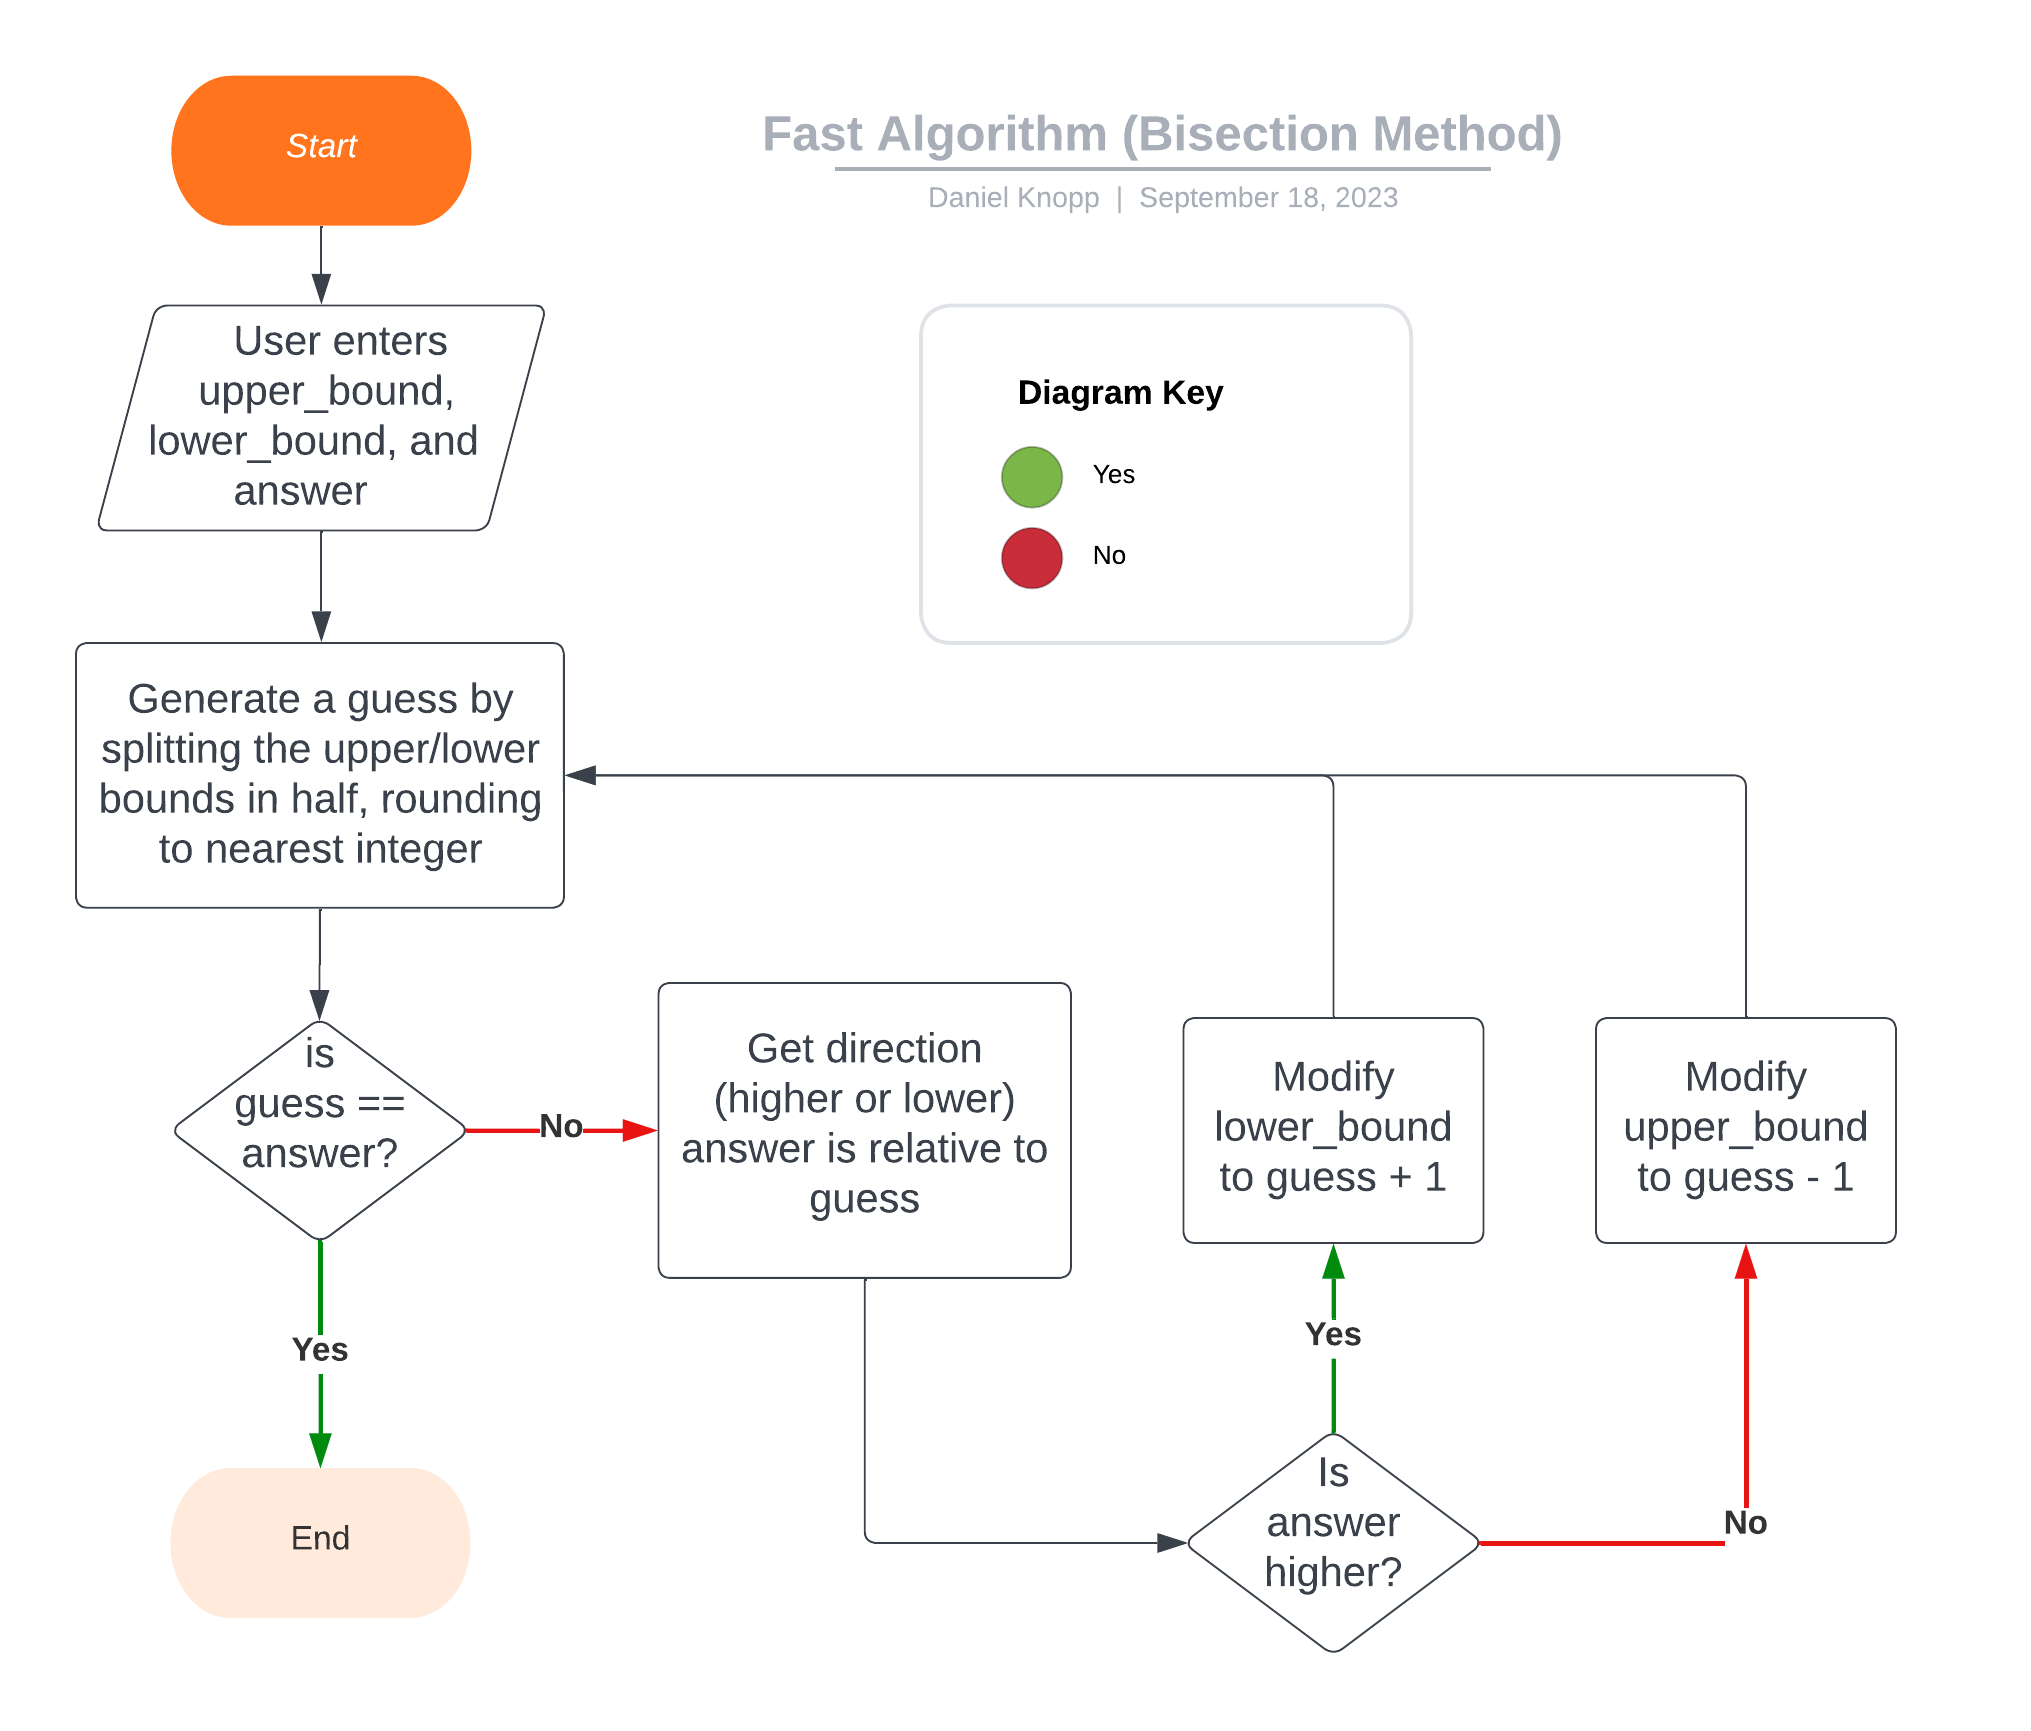

In [2]:
# Display image of fast algorithm workflow diagram
Image(filename='knopp_daniel_assignment_2_fast_workflow.png') 

In [3]:

# Define a function for the fast magic number guessing algorithm
def magic_num_fast(lower_bound: int, upper_bound: int, answer: int) -> int:
    
    # Start timer
    start_time = time.time()

    # Take an initial guess, tick the guess counter, and store the guess
    guess = guess_half_way(lower_bound=lower_bound, upper_bound=upper_bound)
    guess_count = 1
    guesses = [guess]

    # Use a while loop to keep guessing until the anser is found
    while guess != answer:
        
        # Get if answer is higher or lower than the current guess
        direction = is_higher_lower(guess=guess, answer=answer)

        # If direction is higher, go higher by overwriting lower bound with guess + 1
        if direction == 'higher':
            lower_bound = guess + 1

        # Else if direction is lower, go lower by overwriting upper bound with guess - 1
        elif direction == 'lower':
            upper_bound = guess - 1

        # Update guess based on new range, tick guess counter, and store the new guess
        guess = guess_half_way(lower_bound=lower_bound, upper_bound=upper_bound)
        guess_count += 1
        guesses.append(guess)
    
    # Stop timer
    end_time = time.time()

    # Compute duration
    duration = (end_time - start_time)
    
    # Return summary data of the execution
    return (guess, answer, guess_count, duration, guesses)

<div class="alert alert-block alert-info">
We can run a test using the method to make sure it works properly. The range is fully custimizeable here, but for the sake of consistency let's keep the default range of 0-99.
</div>

In [4]:
# Test the fast guesser
(guess, answer, guess_count, duration, guesses) = magic_num_fast(lower_bound=0, upper_bound=99, answer=99)

# If duration is zero, time to execute is less than resolution of time.time() function
if duration == 0:
    time_msg = '<1ms'
else:
    time_msg = f'{duration}s'

# Print summary
print(f'Found answer ({guess}) that matches input ({answer}) after {guess_count} guesses in {time_msg}')

Found answer (99) that matches input (99) after 7 guesses in <1ms


<div class="alert alert-block alert-info">
Above is an example of the worst-case scenario where it takes a maximum of 7 guesses for the range 0-99. Sometimes the duration output is less than 1 ms because time.time() does not have high enough resolution to detect the actual duration of the process. Later we will use a different function for computing average runtimes. 
</div>
<div class="alert alert-block alert-info">
Finally, we create a slow algorithm using similar logic to the bisection method but we will always choose the wrong direction instead of the right one (i.e. if the answer is higher, guess lower). This should allow us to make the maximum number of guesses as possible, on average, since we are actively avoiding the answer instead of converging towards it. It will not be perfectly bad because we cannot guarantee we won't accidentally guess the right number when we need to guess into a range where we know the answer is before we can get more information on how to avoid it.
</div>

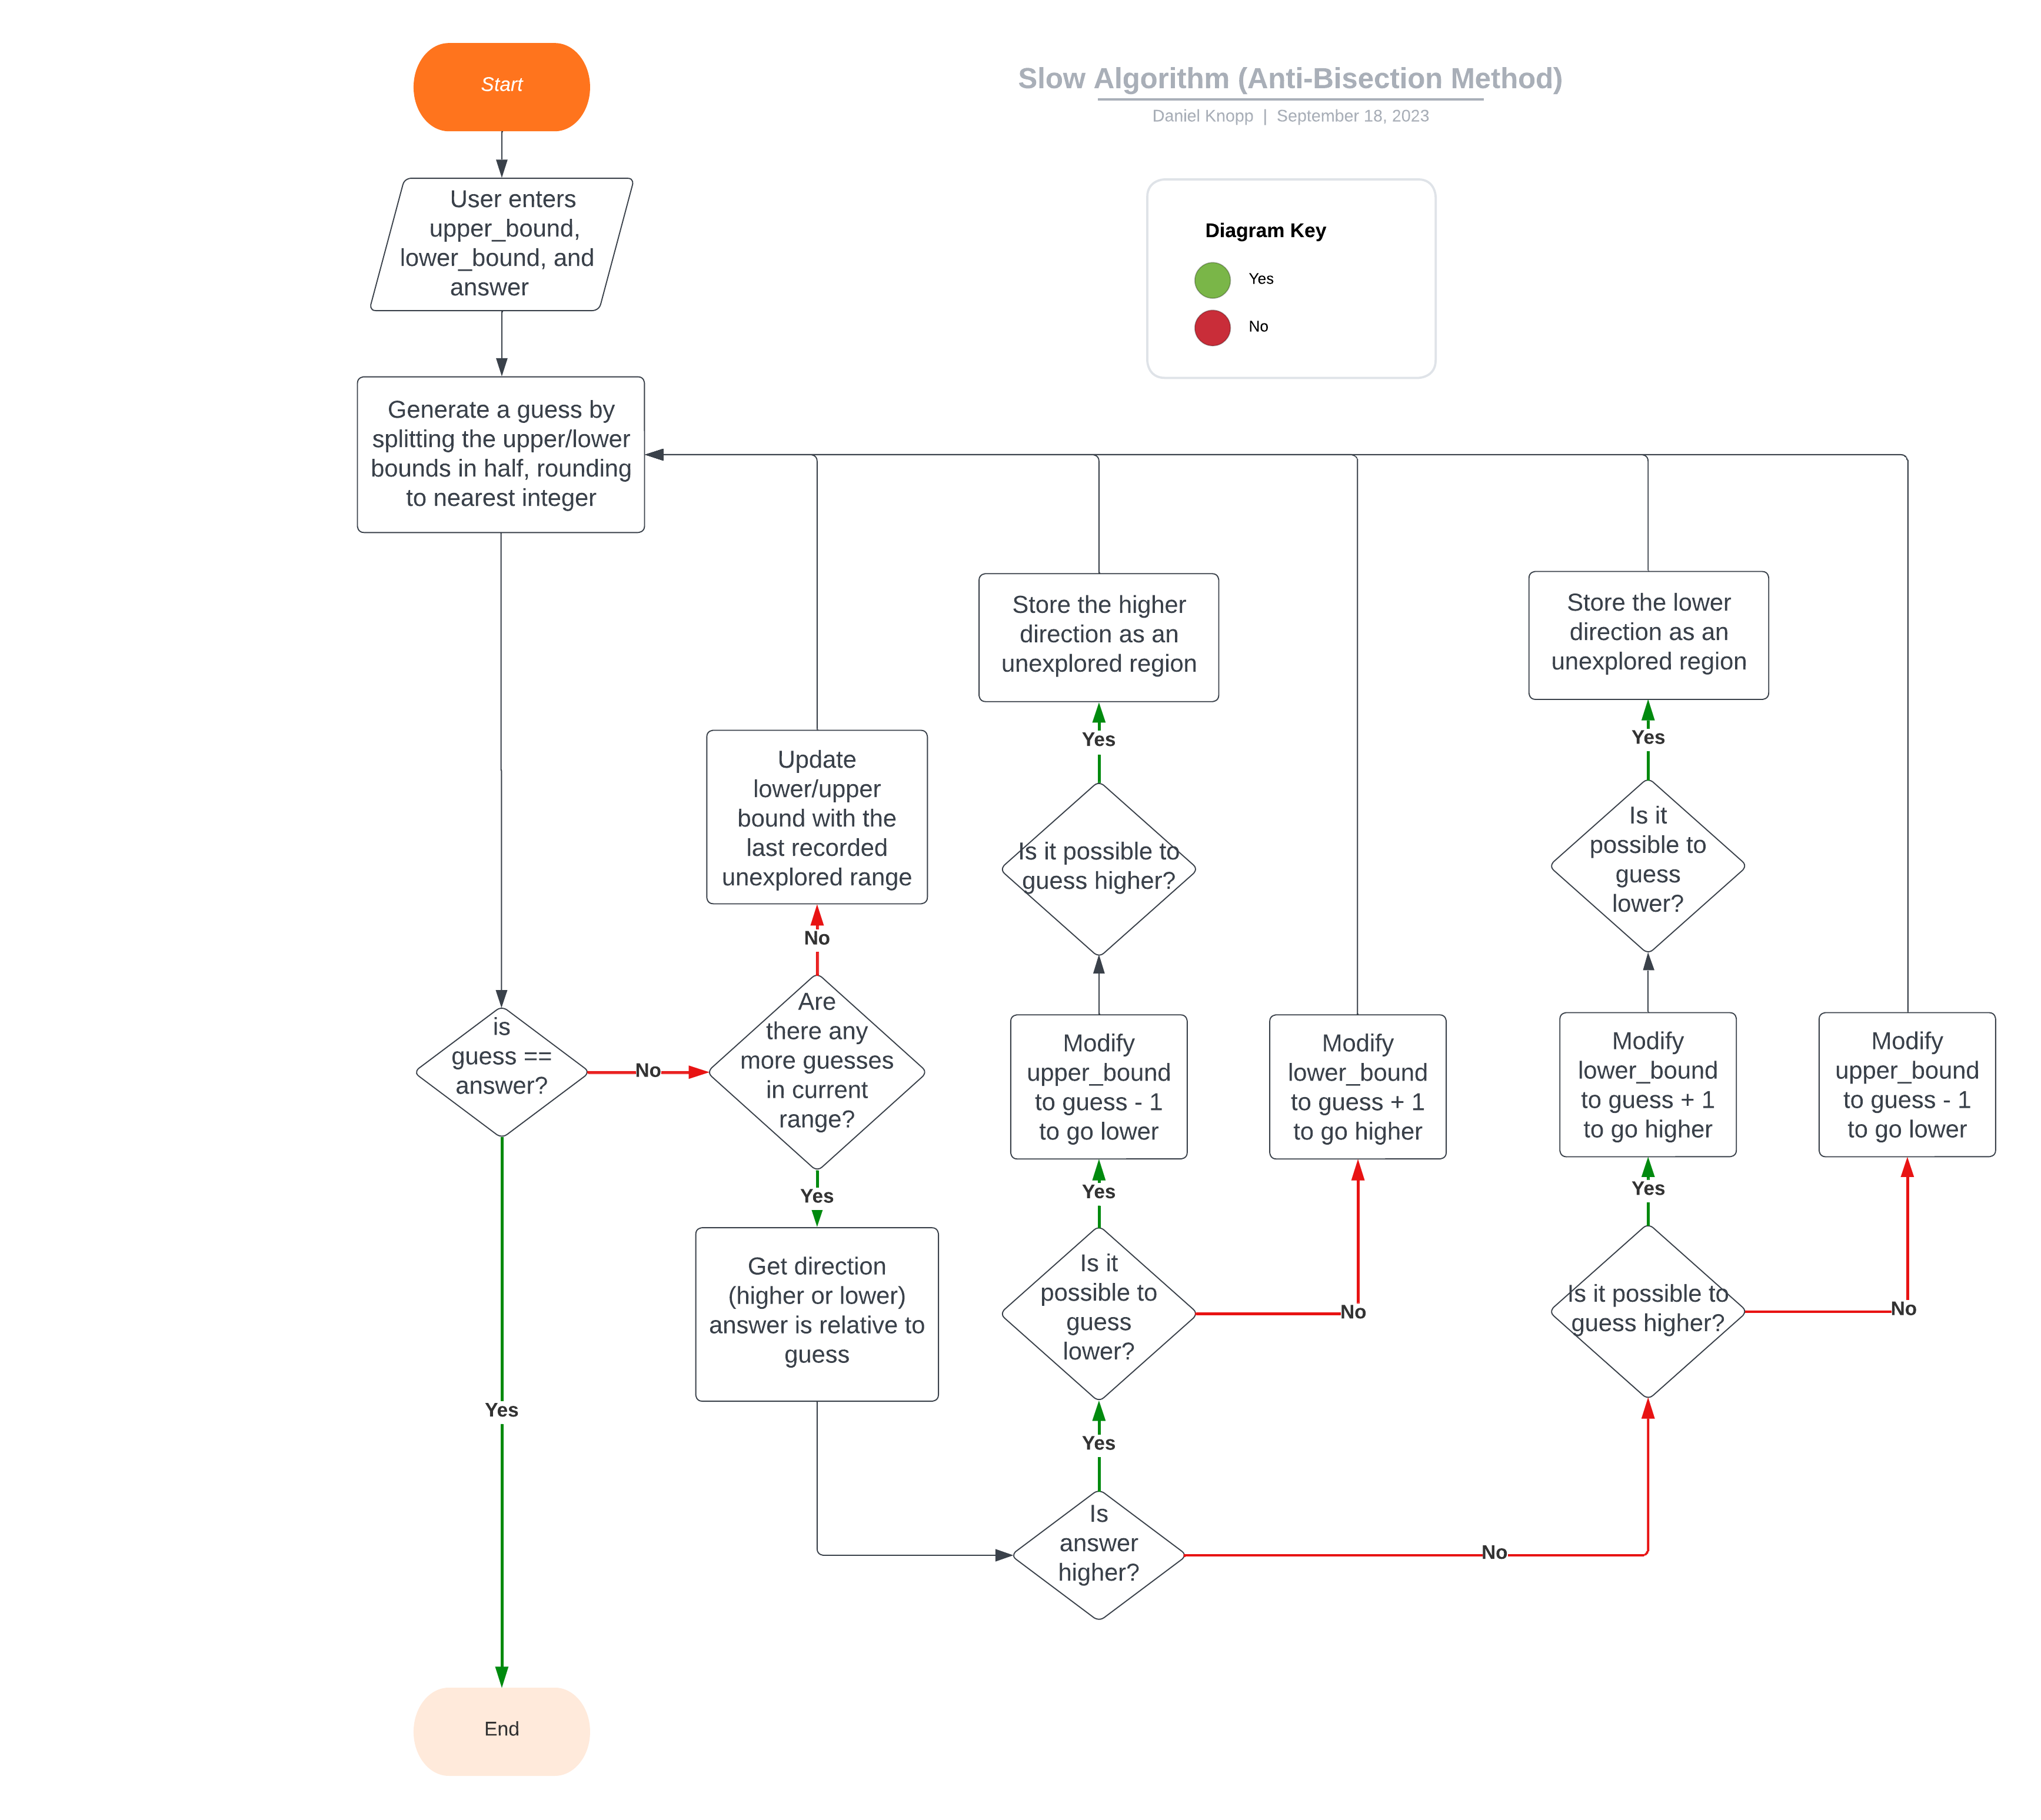

In [5]:
# Display image of slow algorithm workflow diagram
Image(filename='knopp_daniel_assignment_2_slow_workflow.png') 

In [6]:
# Define a function for the slow magic number guessing algorithm
def magic_num_slow(lower_bound: int, upper_bound: int, answer: int) -> int:
    
    # Start timer
    start_time = time.time()

    # Take an initial guess, tick guess counter, and store the guess
    guess = guess_half_way(lower_bound=lower_bound, upper_bound=upper_bound)
    guess_count = 1
    guesses = [guess]

    # For the slow algorithm, we need to keep track of unexplored ranges as we go
    # so we progressively check over them when we exhaust the wrong guesses for a particular range
    # (otherwise the algorithm will diverge and never get a solution)
    unexplored_ranges = queue.LifoQueue() # Lifo is last in first out, so last value put into queue will be the first to come out

    # Use a while loop to keep guessing until the anser is found
    while guess != answer:

        # print(f'{lower_bound} | {guess} | {upper_bound}') # debug message for testing
        
        # If there are more possible guesses in the current range (upper/lower bounds are not yet equal)
        if not lower_bound == upper_bound: 

            # Get if answer is higher or lower than the current guess
            direction = is_higher_lower(guess=guess, answer=answer)

            # If direction is higher
            if direction == 'higher':
                
                # If it's possible to guess lower
                if lower_bound != guess:
                    
                    # If it's possible to guess higher
                    if upper_bound != guess:

                        # Store the higher direction as an unexplored range
                        unexplored_ranges.put((guess + 1, upper_bound))

                    # Go lower by overwriting upper bound with guess - 1
                    upper_bound = guess - 1

                else: # Else we must guess higher

                    # Go higher by overwriting the lower bound with guess + 1
                    lower_bound = guess + 1

            # Else if direction is lower
            elif direction == 'lower':

                # If it's possible to guess higher
                if upper_bound != guess:

                    # If it's possible to guess lower
                    if lower_bound != guess:

                        # Store the lower direction as an unexplored range
                        unexplored_ranges.put((lower_bound, guess - 1))

                    # Go higher by overwriting lower bound with guess + 1
                    lower_bound = guess + 1

                else: # Else we must guess lower

                    # Go lower by overwriting upper bound with guess - 1
                    upper_bound = guess - 1

            # Update guess based on new range
            guess = guess_half_way(lower_bound=lower_bound, upper_bound=upper_bound)

        else: # Else all guesses have been exhausted for current range

            # Get the most recent unexplored range from the unexplored_ranges queue and create another guess based off of it
            (lower_bound, upper_bound) = unexplored_ranges.get()
            guess = guess_half_way(lower_bound=lower_bound, upper_bound=upper_bound)
        
        # Increment guess count and append new guess to guesses list
        guess_count += 1
        guesses.append(guess)

        # print([unexplored_ranges.queue]) # debug message for testing
    
    # Stop timer
    end_time = time.time()

    # Compute duration
    duration = (end_time - start_time)
        
    # Return summary data of the execution
    return  (guess, answer, guess_count, duration, guesses)

<div class="alert alert-block alert-info">
Similar to the fast algorithm, the range is fully custimizeable. Let's run a quick test using the same inputs as with the fast algorithm.
</div>

In [7]:
# Test the slow guesser
(guess, answer, guess_count, duration, guesses) = magic_num_slow(lower_bound=0, upper_bound=99, answer=99)

# If duration is zero, time to execute is less than resolution of time.time() function
if duration == 0:
    time_msg = '<1ms'
else:
    time_msg = f'{duration}s'

# Print summary
print(f'Found answer ({guess}) that matches input ({answer}) after {guess_count} guesses in {time_msg}')

Found answer (99) that matches input (99) after 100 guesses in <1ms


<div class="alert alert-block alert-info">
As you can see, the slow algorithm takes significantly more guesses to arrive at the solution. This specific worst-case example shows that the slow algorithm is able to guess every single other number before arriving at the solution. The time scale here is heavily impacted by background processes ongiong in the machine, so the one-off results aren't a good way of evaluating differences in execution time. Later we will use a more rigorous approach to evaluating the elapsed time differences between algorithms.
</div>
<div class="alert alert-block alert-info">
Now, let's gather some data to create a bar chart to compare the number of guesses and elapsed time it takes to arrive at any number within a default range of 0-99.
</div>

In [8]:
# Store test range and all answers we want to evaluate
lower_bound = 0
upper_bound = 99
answer_list = [i for i in range(lower_bound, upper_bound+1)]

# Execute algorithms to get number of guesses taken
fast_num_guesses = [magic_num_fast(lower_bound=lower_bound, upper_bound=upper_bound, answer=answer)[2] for answer in answer_list]
slow_num_guesses = [magic_num_slow(lower_bound=lower_bound, upper_bound=upper_bound, answer=answer)[2] for answer in answer_list]

<div class="alert alert-block alert-info">
From my testing, using time.time() does not provide high enough resolution to accurately measure the duration of the algorithm. Because of this, I decided to use the "timeit" package as it seems to provide better time resolution for how long the process takes to run on my machine. Below is the code used to get the duration data corresponding to the values stored in the code snippet above. Since I'm running a decent number of iterations for each answer, the code snippet takes a few seconds to execute.
</div>

In [9]:
# Specify the number of iterations to average time data over
num_iterations = 1000

# Initialize storage list variables for durations
fast_durations   = []
slow_durations   = []

# Loop over all answers in list
for answer in answer_list:

    # Define lambda functions for timeit to execute
    fast = lambda: magic_num_fast(lower_bound=lower_bound, upper_bound=upper_bound, answer=answer)
    slow = lambda: magic_num_slow(lower_bound=lower_bound, upper_bound=upper_bound, answer=answer)

    # Time how long it takes to run the algorithms on average over the specified number of iterations of each answer (also convert to microseconds)
    fast_duration = timeit.timeit(fast, number=num_iterations) / num_iterations * 10**6
    slow_duration = timeit.timeit(slow, number=num_iterations) / num_iterations * 10**6

    # Append data to storage lists
    fast_durations.append(fast_duration)
    slow_durations.append(slow_duration)

<div class="alert alert-block alert-info">
Now that we have the data, let's plot it.
</div>

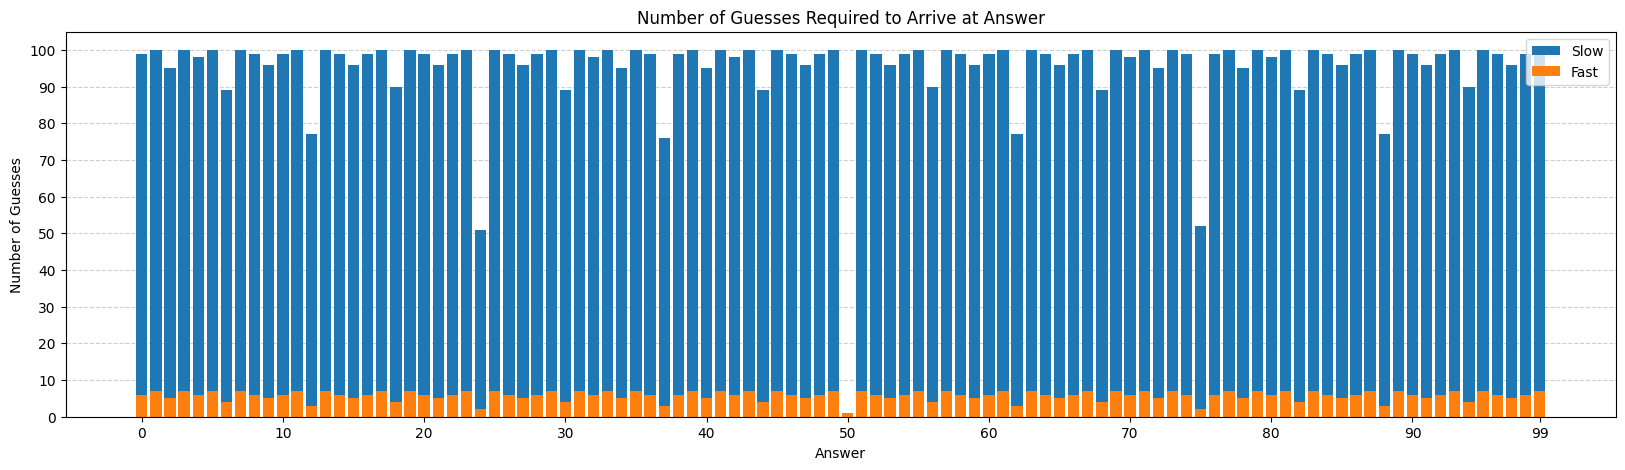

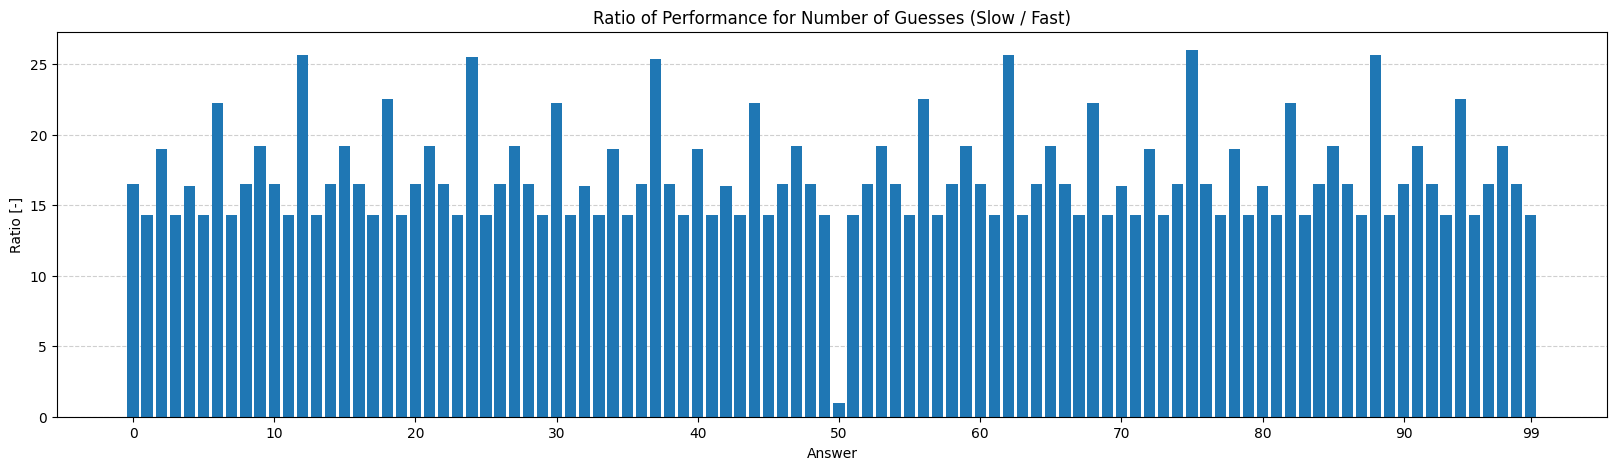

The slow algorithm, on average, requires 89.40 more guesses than the fast algorithm (95.20 vs. 5.80)
Average improvement per answer in number of guesses for fast vs. slow is 16.96 times less guesses

NOTE: summary statistics above are specific to the range: 0-99


In [10]:

# Create a bar graph to comparing number of guesses for each algorithm
plt.figure(figsize=(20,5))
plt.bar(answer_list, slow_num_guesses, label='Slow', zorder=2)
plt.bar(answer_list, fast_num_guesses, label='Fast', zorder=2)
plt.legend()
plt.title('Number of Guesses Required to Arrive at Answer')
plt.xlabel('Answer')
plt.ylabel('Number of Guesses')
plt.xticks([*range(0,100,10),99])
plt.yticks([*range(0,101,10)])
plt.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
plt.show()

# Create a bar graph to comparing number of guesses for each algorithm as a ratio of performance from slow to fast
num_guess_ratio_improv = [slow / fast for slow, fast in zip(slow_num_guesses, fast_num_guesses)]
plt.figure(figsize=(20,5))
plt.bar(answer_list, num_guess_ratio_improv, zorder=2)
plt.title('Ratio of Performance for Number of Guesses (Slow / Fast)')
plt.xlabel('Answer')
plt.ylabel('Ratio [-]')
plt.xticks([*range(0,100,10),99])
plt.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
plt.show()

# Print some comparison statistics
slow_ave_num_guesses = sum(slow_num_guesses) / len(slow_num_guesses)
fast_ave_num_guesses = sum(fast_num_guesses) / len(fast_num_guesses)
print(f'The slow algorithm, on average, requires {slow_ave_num_guesses - fast_ave_num_guesses:.2f} more guesses than the fast algorithm ({slow_ave_num_guesses:.2f} vs. {fast_ave_num_guesses:.2f})')
print(f'Average improvement per answer in number of guesses for fast vs. slow is {sum(num_guess_ratio_improv) / len(num_guess_ratio_improv):.2f} times less guesses')
print(f'\nNOTE: summary statistics above are specific to the range: {lower_bound}-{upper_bound}')

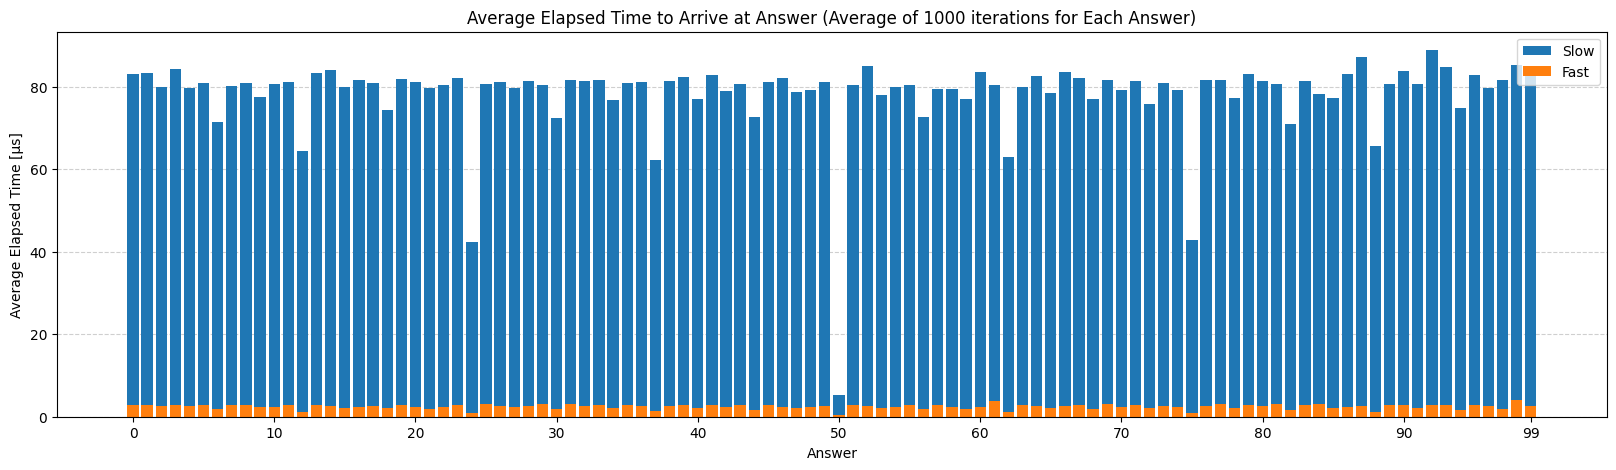

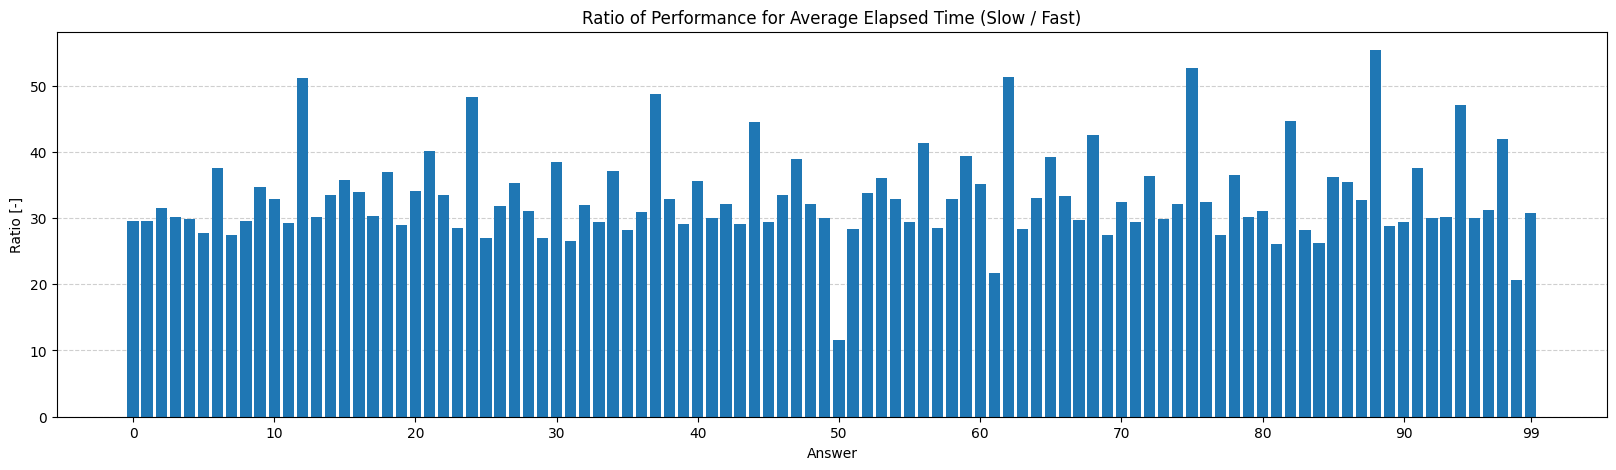

The slow algorithm, on average, takes 75.79μs longer than the fast algorithm (78.23μs vs. 2.44μs)
Average improvement per answer in elapsed time for fast vs. slow is 33.24 times faster

NOTE: summary statistics above are specific to the range: 0-99


In [11]:
# Create a bar graph to comparing elapsed time for each algorithm
plt.figure(figsize=(20,5))
plt.bar(answer_list, slow_durations, label='Slow', zorder=2)
plt.bar(answer_list, fast_durations, label='Fast', zorder=2)
plt.legend()
plt.title(f'Average Elapsed Time to Arrive at Answer (Average of {num_iterations} iterations for Each Answer)')
plt.xlabel('Answer')
plt.ylabel('Average Elapsed Time [\u03BCs]')
plt.xticks([*range(0,100,10),99])
plt.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
plt.show()

# Create a bar graph to comparing elapsed time for each algorithm as a ratio of performance from slow to fast
duration_ratio_improv = [slow / fast for slow, fast in zip(slow_durations, fast_durations)]
plt.figure(figsize=(20,5))
plt.bar(answer_list, duration_ratio_improv, zorder=2)
plt.title('Ratio of Performance for Average Elapsed Time (Slow / Fast)')
plt.xlabel('Answer')
plt.ylabel('Ratio [-]')
plt.xticks([*range(0,100,10),99])
plt.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
plt.show()

# Print some comparison statistics
slow_ave_duration = sum(slow_durations) / len(slow_durations)
fast_ave_duration = sum(fast_durations) / len(fast_durations)
print(f'The slow algorithm, on average, takes {slow_ave_duration - fast_ave_duration:.2f}\u03BCs longer than the fast algorithm ({slow_ave_duration:.2f}\u03BCs vs. {fast_ave_duration:.2f}\u03BCs)')
print(f'Average improvement per answer in elapsed time for fast vs. slow is {sum(duration_ratio_improv) / len(duration_ratio_improv):.2f} times faster')
print(f'\nNOTE: summary statistics above are specific to the range: {lower_bound}-{upper_bound}')

<div class="alert alert-block alert-info">
It is interesting to note that the improvement in elapsed time performance is not equal to the improvement in the number of guesses. The slow algorithm not only requires more guesses to arrive at the answer, but it is also substantially less computationally efficient per guess than the fast algorithm. This makes sense as there are a lot more variable assignments and logical operations going on inside the slow function which the fast function does not need. 
</div>
<div class="alert alert-block alert-info">
Finally, lets create an animation showing the progression of guesses by each algorithm for a specific number in the default range. Note that this takes some time to compute the animation, so please be patient while the next code snippet executes.
</div>

In [12]:
# Import modules needed for creating an animation
%matplotlib notebook
import matplotlib.animation
import numpy as np

# Store the guessing process for each algorithm and a specific answer value
(lower_bound, answer, upper_bound) = (0, 43, 99)
fast_guesses = magic_num_fast(lower_bound=lower_bound, upper_bound=upper_bound, answer=answer)[4]
slow_guesses = magic_num_slow(lower_bound=lower_bound, upper_bound=upper_bound, answer=answer)[4]

# Duplicate the last number of the fast guesses until the same length as slow guesses
fast_guesses = fast_guesses + [fast_guesses[-1]] * (len(slow_guesses) - len(fast_guesses))

# Create an answer list the same length as the slow_guesses
answers = [answer] * len(slow_guesses)

# Setup figure
fig = plt.figure(figsize=(25,5))
axe = fig.add_subplot(1,1,1)
axe.set_xlim(0, 99)

# Show vertical grid lines (labels not as frequently as lines)
plt.grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
tick_labels = [str(i) if i % 10 == 0 else '' for i in np.arange(0, 101, 1)]
tick_labels[-2:] = ['99', '']
plt.xticks(np.arange(0, 101, 1), tick_labels)

# Add a title
plt.title(label=f'Animation of Fast and Slow Algorithms to Guess the Number: {answer} in range {lower_bound}-{upper_bound}')

# Create function that matplotlib will use for animation
def animate(i):

    # Initialize plot colors for Fast, Answer, and Slow - respectively
    colors = ['blue', 'green', 'red']

    # Loop over all data until current frame
    for j in range(i):

         # override color to green when plotting the guess == answer
        if fast_guesses[j] == answers[j]: colors[0] = 'green'
        if slow_guesses[j] == answers[j]: colors[2] = 'green'

        # Plot guesses and answer
        plt.barh(['Fast Algorithm', 'Answer', 'Slow Algorithm'], [1, 1, 1], left=[fast_guesses[j], answers[j], slow_guesses[j]], color=colors, edgecolor='black', zorder=2)

         # reset colors back to default
        colors = ['blue', 'green', 'red']

# Setup the animation
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(answers)+1)

# Run the animation
print('Please be patient, the animation takes a while to build...')
plt.rcParams["animation.html"] = "jshtml"
ani

<IPython.core.display.Javascript object>

Please be patient, the animation takes a while to build...


<div class="alert alert-block alert-info">
<b> NOTE: </b>
In order to run any previous code snippets that create graphs after the animation has been generated you need to restart the Jupyter notebook kernel (not clear why, but the matplotlib plugin used to make the animation causes issues with the previous matplotlib plotting code)
</div>